
# 1. Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import math
import xgboost as xgb 
import scipy
from scipy.stats import variation
%matplotlib inline
warnings.filterwarnings('ignore')
sb.set_style("darkgrid")
import sklearn
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import f_oneway

from sklearn.ensemble import RandomForestRegressor


# 2. Load dataset

In [2]:
#Load dataset
data = pd.read_csv('supermarket_sales - Sheet1.csv') 
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


# 3. Understand data

In [3]:
# Explore the datatypes, unique values, null values etc. to understand the data
data.shape

(1000, 17)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [5]:
data.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


In [6]:
data.isnull().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

In [7]:
data['Branch'].unique()

array(['A', 'C', 'B'], dtype=object)

In [8]:
data['City'].unique()

array(['Yangon', 'Naypyitaw', 'Mandalay'], dtype=object)

In [9]:
data['Customer type'].unique()

array(['Member', 'Normal'], dtype=object)

In [10]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [11]:
data['Product line'].unique()

array(['Health and beauty', 'Electronic accessories',
       'Home and lifestyle', 'Sports and travel', 'Food and beverages',
       'Fashion accessories'], dtype=object)

In [12]:
data['Date'].unique()

array(['1/5/2019', '3/8/2019', '3/3/2019', '1/27/2019', '2/8/2019',
       '3/25/2019', '2/25/2019', '2/24/2019', '1/10/2019', '2/20/2019',
       '2/6/2019', '3/9/2019', '2/12/2019', '2/7/2019', '3/29/2019',
       '1/15/2019', '3/11/2019', '1/1/2019', '1/21/2019', '3/5/2019',
       '3/15/2019', '2/17/2019', '3/2/2019', '3/22/2019', '3/10/2019',
       '1/25/2019', '1/28/2019', '1/7/2019', '3/23/2019', '1/17/2019',
       '2/2/2019', '3/4/2019', '3/16/2019', '2/27/2019', '2/10/2019',
       '3/19/2019', '2/3/2019', '3/7/2019', '2/28/2019', '3/27/2019',
       '1/20/2019', '3/12/2019', '2/15/2019', '3/6/2019', '2/14/2019',
       '3/13/2019', '1/24/2019', '1/6/2019', '2/11/2019', '1/22/2019',
       '1/13/2019', '1/9/2019', '1/12/2019', '1/26/2019', '1/23/2019',
       '2/23/2019', '1/2/2019', '2/9/2019', '3/26/2019', '3/1/2019',
       '2/1/2019', '3/28/2019', '3/24/2019', '2/5/2019', '1/19/2019',
       '1/16/2019', '1/8/2019', '2/18/2019', '1/18/2019', '2/16/2019',
       '2/22/201

In [13]:
data['Payment'].unique()

array(['Ewallet', 'Cash', 'Credit card'], dtype=object)

In [14]:
data['Rating'].unique()

array([ 9.1,  9.6,  7.4,  8.4,  5.3,  4.1,  5.8,  8. ,  7.2,  5.9,  4.5,
        6.8,  7.1,  8.2,  5.7,  4.6,  6.9,  8.6,  4.4,  4.8,  5.1,  9.9,
        6. ,  8.5,  6.7,  7.7,  7.5,  7. ,  4.7,  7.6,  7.9,  6.3,  5.6,
        9.5,  8.1,  6.5,  6.1,  6.6,  5.4,  9.3, 10. ,  6.4,  4.3,  4. ,
        8.7,  9.4,  5.5,  8.3,  7.3,  4.9,  4.2,  9.2,  7.8,  5.2,  9. ,
        8.8,  6.2,  9.8,  9.7,  5. ,  8.9])

# 4. Set Date column to index

In [15]:
#Set date column to index also set its datatype to datetime datatype for better data analysis
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 6. Split data into train and test data

In [16]:
#First step is to split the dataset into train and test dataset. So that we donot use test dataset for data exploration.
d =data.sort_values(by='Date')
train_len = 796
train = d[0:train_len]
test = d[train_len : ]
test.shape


(204, 16)

In [17]:
train.shape

(796, 16)

In [18]:
# Create a new column from date column. Done as a part of feature engineering.
train['Day Of Week'] = train.index.dayofweek
test['Day Of Week'] = test.index.dayofweek

# 5. EDA

# 5.1. Univariate Analysis 

Histograms for numerical columns
********************************


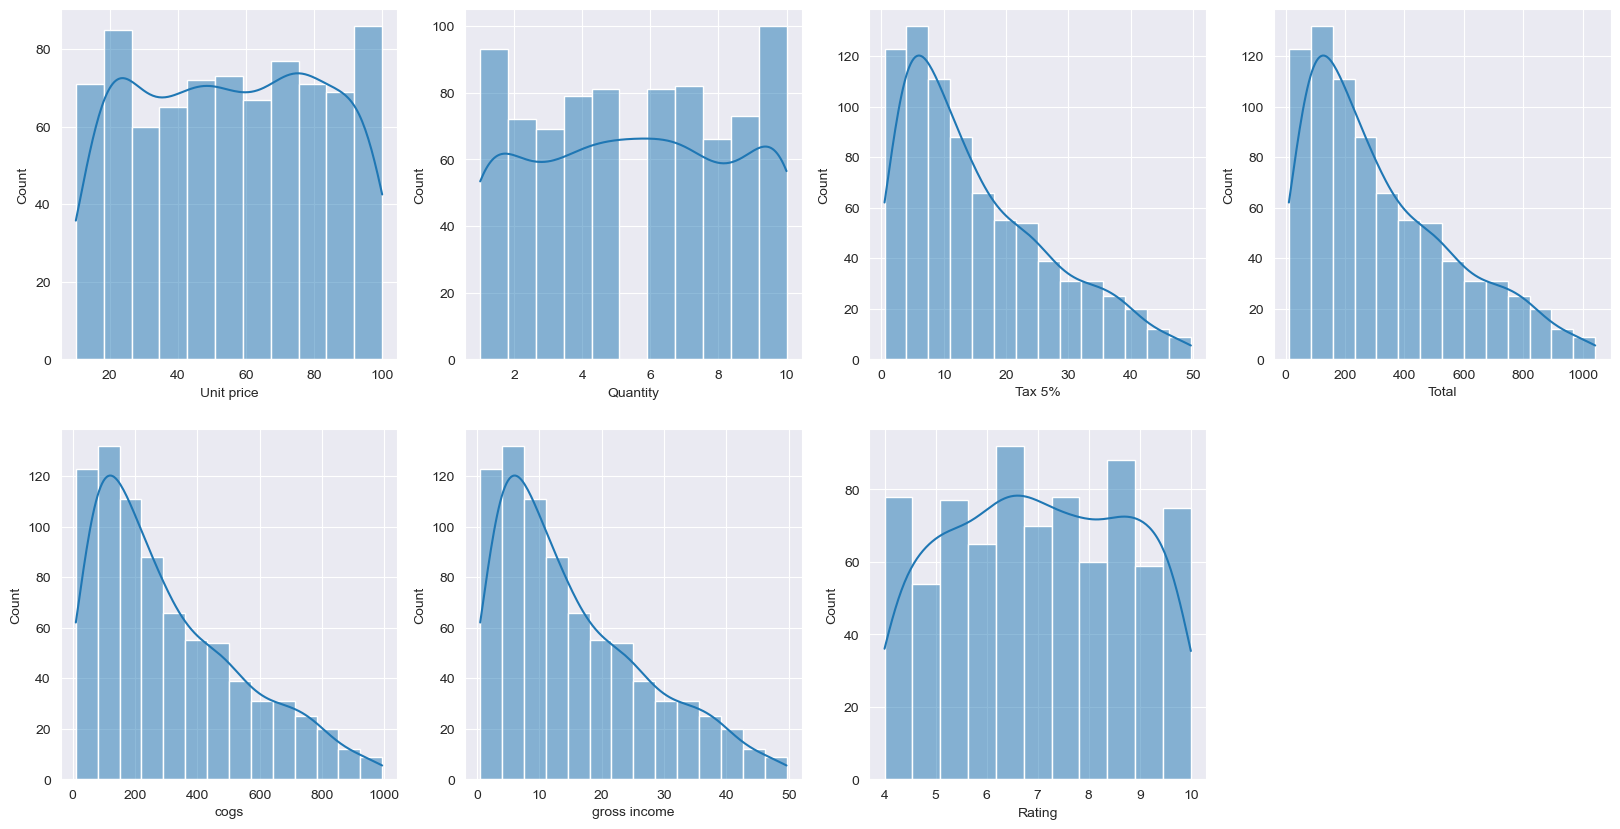

Bar plots for categorical columns
*********************************


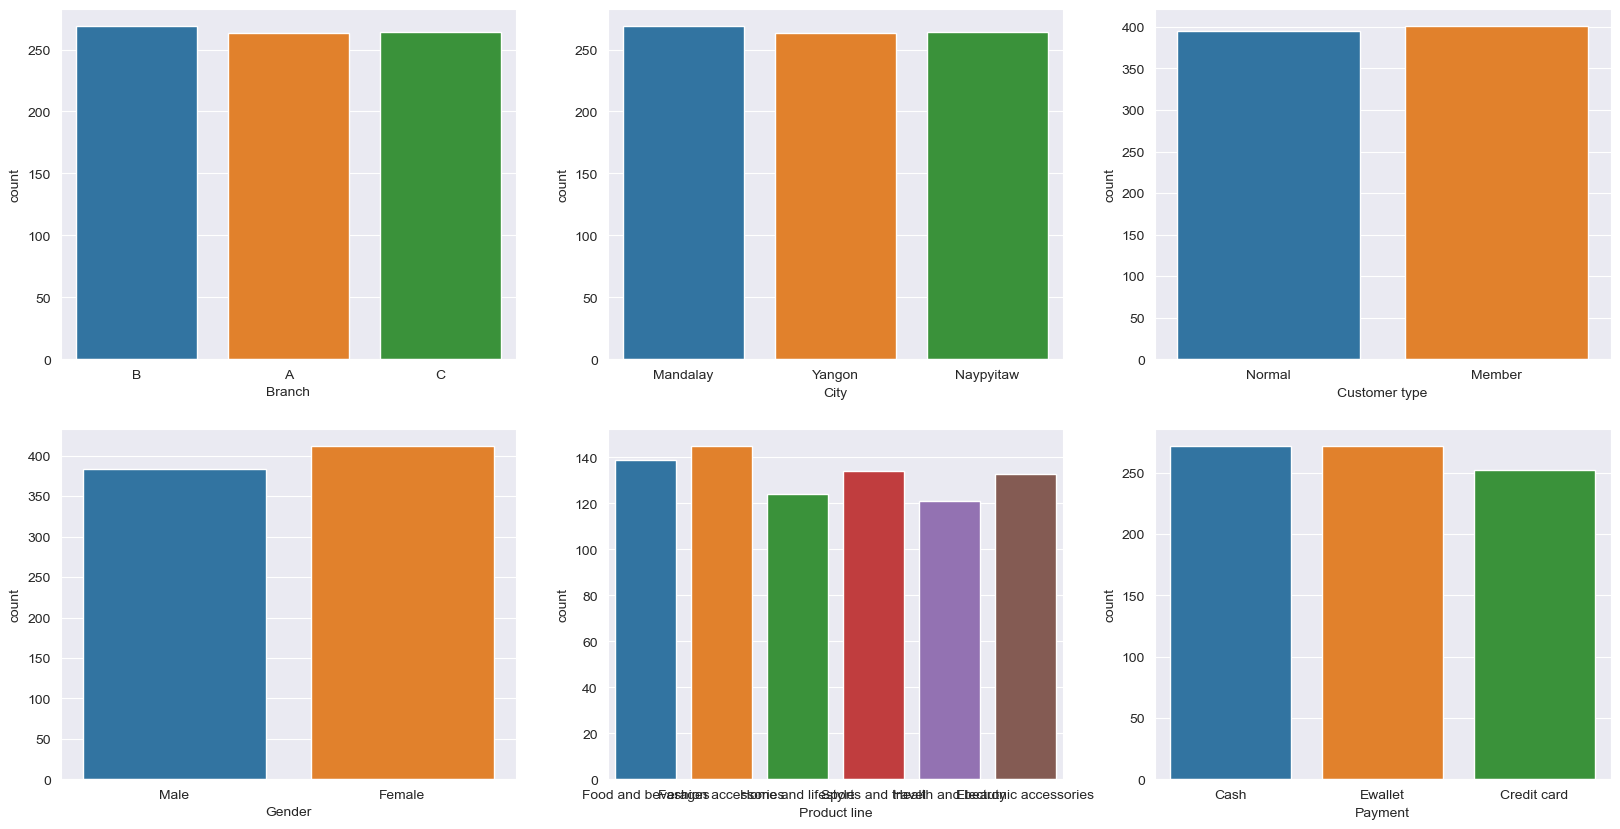

In [19]:
# Histograms for numerical columns
print("Histograms for numerical columns")
print("********************************")
fig, axs = plt.subplots(2,4,figsize=(20, 10))
sb.histplot(train['Unit price'],kde=True, ax=axs[0, 0] )
sb.histplot(train['Quantity'],kde=True, ax=axs[0, 1] )
sb.histplot(train['Tax 5%'],kde=True, ax=axs[0, 2] )
sb.histplot(train['Total'],kde=True, ax=axs[0, 3] )
sb.histplot(train['cogs'],kde=True, ax=axs[1, 0] )
sb.histplot(train['gross income'],kde=True, ax=axs[1, 1] )
sb.histplot(train['Rating'],kde=True, ax=axs[1, 2] )


fig.delaxes(axs[1,3])
plt.show()


print("Bar plots for categorical columns")
print("*********************************")

fig2, axs2 = plt.subplots(2,3,figsize=(20, 10))
sb.countplot(train['Branch'], ax=axs2[0, 0] )
sb.countplot(train['City'], ax=axs2[0, 1] )
sb.countplot(train['Customer type'], ax=axs2[0, 2] )
sb.countplot(train['Gender'], ax=axs2[1, 0] )
sb.countplot(train['Product line'], ax=axs2[1, 1] )
sb.countplot(train['Payment'], ax=axs2[1, 2] )



plt.show()



# Findings from Univariate analysis

1. Most of the Unit prices falls in between 50-100.
2. Quantity per transaction seem to be evenly distributed.
3. cogs, Tax 5%, Total, and gross income are right skewed. Tax 5%, Total, and gross income mirrors the distribution of cogs, which is expected since they are derived from cogs.
4. Majority of customer ratings are in the range of 6 to 8.
5. Branch A and B has slightly more transactions than B.
6. Yangon and Mandalay have slightly more transactions than Naypyitaw.
7. Both customer types have almost equal number of transactions
8. Number of female and male customers are almost equal.
9. Distribution of transaction across product lines are similar with Fashion and accessories slightly higher.
10. Ewallet and Cash Payment have similar transaction counts with Ewallet slightly leading. Credit card option is the less chosen method of payment.





# 5.2. Bivariate Analysis
## Correlation Matrix

1. 'gross margin percentage' has constant values. This could result in NaN values during correlation analysis. To avoid this issue we remove such columns.
2. 'cogs', 'Tax 5%', and 'gross income' are fully correlated to 'Total' since they are derived from 'Total'. They are also removed.

In [20]:
d1 = train.drop(['gross margin percentage','cogs','Tax 5%','gross income'],axis=1)
d2 = test.drop(['gross margin percentage','cogs','Tax 5%','gross income'],axis=1)

### One Hot Encoding for categorical columns

In [21]:
data_encoded = pd.get_dummies(d1, columns=['Gender', 'Payment','Branch','City','Customer type','Product line'])


data_encodedT = pd.get_dummies(d2, columns=['Gender', 'Payment','Branch','City','Customer type','Product line'])


In [22]:
numerical_features = ['Unit price', 'Total', 'Rating', 'Quantity']
numerical_data_encoded = data_encoded[numerical_features]
correlation_matrix = numerical_data_encoded.corr()
correlation_matrix

,Unit price,Total,Rating,Quantity
Unit price,1.000000,0.628175,-0.009835,0.007176
Total,0.628175,1.000000,-0.031241,0.709140
Rating,-0.009835,-0.031241,1.000000,-0.007480
Quantity,0.007176,0.709140,-0.007480,1.000000


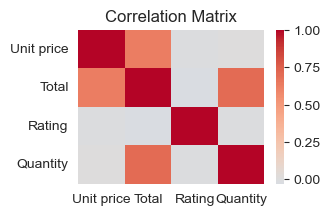

In [23]:
plt.figure(figsize=(3, 2))
sb.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

### Results from Correlation matrix
Unit price and Quantity seems to be more correlated to Total compared to Rating.

# 6. Exponential Smoothing Technique

Exponential smoothing is primarily focused on modeling and forecasting time-dependent patterns in a single time series variable, rather than dealing with multiple  features. So previous values of sales will be used to predict the future values.

In [24]:
data1 = train.groupby(['Date'])['Total'].sum()
data1 = pd.DataFrame(data1)


In [25]:
data2= test.groupby(['Date'])['Total'].sum()
data2 = pd.DataFrame(data2)


# 7. Choose the column to forecast and other parameters

In [26]:
sales_column = 'Total'
# Weekly seasonality
seasonality_period = 7  
num_steps = 19

# 8. Fit the model and forecast for additive method

In [27]:
modeladd = ExponentialSmoothing(data1[sales_column], trend='add', seasonal='add', seasonal_periods=seasonality_period)
fitted_model = modeladd.fit()

forecastadd = fitted_model.forecast(steps=num_steps)

C:\Users\aveli\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\aveli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# 9. Plot result for Holt Winters' Additive Method

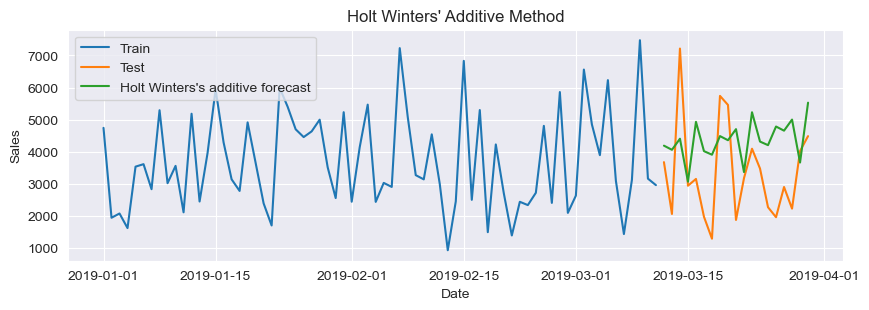

In [28]:
def Plot(label,data1,data2,forecast,title):
    
    plt.figure(figsize=(10,3))
    plt.plot( data1['Total'], label='Train')
    plt.plot(data2['Total'], label='Test')
    plt.plot(forecast, label=label)
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(title)
    plt.show()
    
Plot(label = 'Holt Winters\'s additive forecast',title = 'Holt Winters\' Additive Method', data1 = data1,data2 = data2,forecast = forecastadd)

# 10. Fit the model and forecast for multiplicative method

In [29]:
modelmul = ExponentialSmoothing(data1[sales_column], trend='add', seasonal='mul', seasonal_periods=seasonality_period)
fitted_model = modelmul.fit()
forecastmul = fitted_model.forecast(steps=num_steps)

C:\Users\aveli\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\aveli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# 11. Plot result for Holt Winters' Multiplicative Method

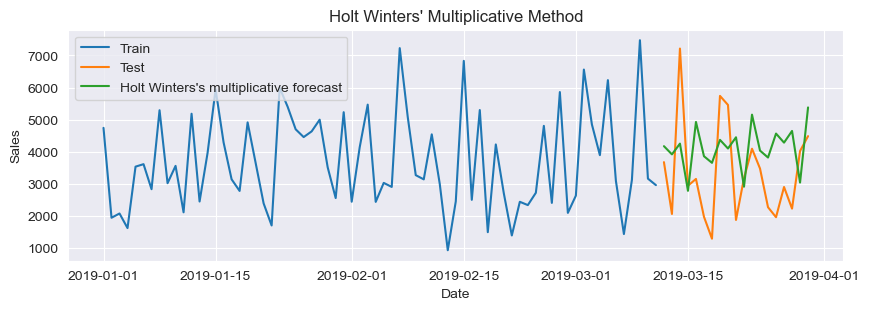

In [30]:
Plot(label = 'Holt Winters\'s multiplicative forecast',title = 'Holt Winters\' Multiplicative Method', data1 = data1,data2 = data2,forecast = forecastmul)

# 12. Fit the model and forcast for Random Forest method

In [31]:
data_encoded.keys()

Index(['Invoice ID', 'Unit price', 'Quantity', 'Total', 'Time', 'Rating',
       'Day Of Week', 'Gender_Female', 'Gender_Male', 'Payment_Cash',
       'Payment_Credit card', 'Payment_Ewallet', 'Branch_A', 'Branch_B',
       'Branch_C', 'City_Mandalay', 'City_Naypyitaw', 'City_Yangon',
       'Customer type_Member', 'Customer type_Normal',
       'Product line_Electronic accessories',
       'Product line_Fashion accessories', 'Product line_Food and beverages',
       'Product line_Health and beauty', 'Product line_Home and lifestyle',
       'Product line_Sports and travel'],
      dtype='object')

In [32]:
features = ['City_Mandalay', 'City_Naypyitaw', 'City_Yangon', 'Unit price', 'Total','Day Of Week','Branch_A', 'Branch_B','Branch_C','Quantity','Rating','Gender_Female','Gender_Male','Payment_Ewallet','Customer type_Member',
       'Customer type_Normal', 'Product line_Electronic accessories',
       'Product line_Fashion accessories', 'Product line_Food and beverages',
       'Product line_Health and beauty', 'Product line_Home and lifestyle',
       'Product line_Sports and travel']

X_train = data_encoded[features]
Y_train = data_encoded['Total']


X_test = data_encodedT[features]
Y_test = data_encodedT['Total']


RFmodel = RandomForestRegressor(n_estimators=100, random_state=42)
RFmodel.fit(X_train, Y_train)

Y_pred = RFmodel.predict(X_test)
Y_pred = pd.DataFrame(Y_pred)
Y_test = pd.DataFrame(Y_test)
Y_test.reset_index(inplace = True)
Y_test['pred'] = Y_pred

Y_test.set_index('Date', inplace=True)

Y_pred = Y_test.groupby(['Date'])['pred'].sum()
Y_pred = pd.DataFrame(Y_pred)
Y_test= Y_test.groupby(['Date'])['Total'].sum()
Y_test = pd.DataFrame(Y_test)


Y_train = pd.DataFrame(Y_train)
Y_train= Y_train.groupby(['Date'])['Total'].sum()
Y_train = pd.DataFrame(Y_train)

feature_importances = RFmodel.feature_importances_

feature_importance_dict = dict(zip(X_train.columns, feature_importances))

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance:.7f}")
    
    

Total: 0.9998839
Unit price: 0.0000523
Rating: 0.0000156
Day Of Week: 0.0000095
Quantity: 0.0000042
Customer type_Member: 0.0000035
Gender_Male: 0.0000028
Product line_Sports and travel: 0.0000028
Customer type_Normal: 0.0000028
Gender_Female: 0.0000027
Product line_Fashion accessories: 0.0000025
Product line_Home and lifestyle: 0.0000023
Payment_Ewallet: 0.0000020
Branch_B: 0.0000019
City_Naypyitaw: 0.0000017
City_Yangon: 0.0000016
Branch_A: 0.0000015
Branch_C: 0.0000014
Product line_Electronic accessories: 0.0000014
City_Mandalay: 0.0000013
Product line_Food and beverages: 0.0000013
Product line_Health and beauty: 0.0000012


In [33]:
# Perform ANOVA
anova_result = f_oneway(*[group['Total'] for location, group in train.groupby('Unit price')])

anova_result = f_oneway(*[group['Total'] for location, group in train.groupby('Gender')])
# Print the ANOVA result
print("ANOVA Result:")
print("F-statistic for Gender:", anova_result.statistic)
print("p-value for Gender:", anova_result.pvalue)

anova_result = f_oneway(*[group['Total'] for location, group in train.groupby('Customer type')])
# Print the ANOVA result
print("ANOVA Result:")
print("F-statistic for Customer type:", anova_result.statistic)
print("p-value for Customer type:", anova_result.pvalue)

anova_result = f_oneway(*[group['Total'] for location, group in train.groupby('Product line')])
# Print the ANOVA result
print("ANOVA Result:")
print("F-statistic for Product line:", anova_result.statistic)
print("p-value for Product line:", anova_result.pvalue)


anova_result = f_oneway(*[group['Total'] for location, group in train.groupby('Payment')])
# Print the ANOVA result
print("ANOVA Result:")
print("F-statistic for Payment:", anova_result.statistic)
print("p-value for Payment:", anova_result.pvalue)


anova_result = f_oneway(*[group['Total'] for location, group in train.groupby('Branch')])
# Print the ANOVA result
print("ANOVA Result:")
print("F-statistic for Branch:", anova_result.statistic)
print("p-value for Branch:", anova_result.pvalue)


anova_result = f_oneway(*[group['Total'] for location, group in train.groupby('City')])
# Print the ANOVA result
print("ANOVA Result:")
print("F-statistic for City:", anova_result.statistic)
print("p-value for City:", anova_result.pvalue)




ANOVA Result:
F-statistic for Gender: 5.146252659333951
p-value for Gender: 0.023564291543047906
ANOVA Result:
F-statistic for Customer type: 0.6288883614936527
p-value for Customer type: 0.4280002618793317
ANOVA Result:
F-statistic for Product line: 0.4242449531142252
p-value for Product line: 0.8319625390500863
ANOVA Result:
F-statistic for Payment: 1.5889639580239834
p-value for Payment: 0.20478624077134683
ANOVA Result:
F-statistic for Branch: 0.38991603316465934
p-value for Branch: 0.6772434713079744
ANOVA Result:
F-statistic for City: 0.38991603316465934
p-value for City: 0.6772434713079744


# 12. Fit the model and forcast for Random Forest method

In [34]:
features = [ 'Unit price', 'Total', 'Branch_A', 'Branch_B','Branch_C','City_Mandalay', 'City_Naypyitaw', 'City_Yangon','Day Of Week']

X_train = data_encoded[features]
Y_train = data_encoded['Total']

#print(X_train.shape)
#print(X_test.shape)
X_test = data_encodedT[features]
Y_test = data_encodedT['Total']


RFmodel = RandomForestRegressor(n_estimators=100, random_state=42)
RFmodel.fit(X_train, Y_train)

Y_pred = RFmodel.predict(X_test)
Y_pred = pd.DataFrame(Y_pred)
Y_test = pd.DataFrame(Y_test)
Y_test.reset_index(inplace = True)
Y_test['pred'] = Y_pred

Y_test.set_index('Date', inplace=True)

Y_pred = Y_test.groupby(['Date'])['pred'].sum()
Y_pred = pd.DataFrame(Y_pred)
Y_test= Y_test.groupby(['Date'])['Total'].sum()
Y_test = pd.DataFrame(Y_test)


Y_train = pd.DataFrame(Y_train)
Y_train= Y_train.groupby(['Date'])['Total'].sum()
Y_train = pd.DataFrame(Y_train)

feature_importances = RFmodel.feature_importances_

feature_importance_dict = dict(zip(X_train.columns, feature_importances))

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance:.7f}")
    
    


Total: 0.9999260
Unit price: 0.0000459
Day Of Week: 0.0000152
City_Naypyitaw: 0.0000025
Branch_C: 0.0000024
Branch_B: 0.0000020
City_Yangon: 0.0000020
Branch_A: 0.0000020
City_Mandalay: 0.0000019


In [35]:
features = ['City_Mandalay', 'City_Naypyitaw', 'City_Yangon', 'Unit price', 'Total','Day Of Week','Branch_A', 'Branch_B','Branch_C']

X_trainL = data_encoded[features]
Y_trainL = data_encoded['Total']
lag = X_trainL['Total'].shift()
X_trainL['Lag_Variable'] = lag

X_trainL = X_trainL.iloc[1:]
Y_trainL = Y_trainL.iloc[1:]

X_testL = data_encodedT[features]
Y_testL = data_encodedT['Total']
lagT = X_testL['Total'].shift()
X_testL['Lag_Variable'] = lagT

X_testL = X_testL.iloc[1:]
Y_testL = Y_testL.iloc[1:]



RFmodelL = RandomForestRegressor(n_estimators=100, random_state=42)
RFmodelL.fit(X_trainL, Y_trainL)

Y_predL = RFmodelL.predict(X_testL)
Y_predL = pd.DataFrame(Y_predL)
Y_testL = pd.DataFrame(Y_testL)
Y_testL.reset_index(inplace = True)
Y_testL['pred'] = Y_predL

Y_testL.set_index('Date', inplace=True)

Y_predL = Y_testL.groupby(['Date'])['pred'].sum()
Y_predL = pd.DataFrame(Y_predL)
Y_testL= Y_testL.groupby(['Date'])['Total'].sum()
Y_testL = pd.DataFrame(Y_testL)


Y_trainL = pd.DataFrame(Y_trainL)
Y_trainL= Y_trainL.groupby(['Date'])['Total'].sum()
Y_trainL = pd.DataFrame(Y_trainL)

feature_importancesL = RFmodelL.feature_importances_

feature_importance_dictL = dict(zip(X_trainL.columns, feature_importancesL))

sorted_feature_importanceL = dict(sorted(feature_importance_dictL.items(), key=lambda item: item[1], reverse=True))

for feature, importance in sorted_feature_importanceL.items():
    print(f"{feature}: {importance:.7f}")
    
    


Total: 0.9999126
Unit price: 0.0000395
Lag_Variable: 0.0000222
Day Of Week: 0.0000106
Branch_A: 0.0000027
City_Naypyitaw: 0.0000026
Branch_C: 0.0000025
City_Yangon: 0.0000024
Branch_B: 0.0000024
City_Mandalay: 0.0000024


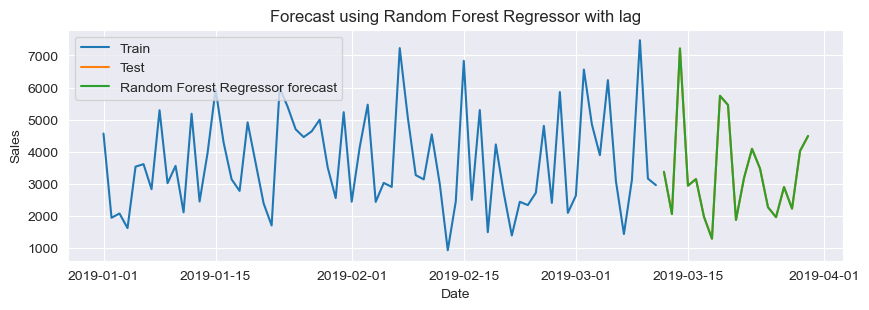

In [36]:
Plot(label = 'Random Forest Regressor forecast',title = 'Forecast using Random Forest Regressor with lag', data1 = Y_trainL,data2 = Y_testL,forecast = Y_predL['pred'])

### 13. Plot the result

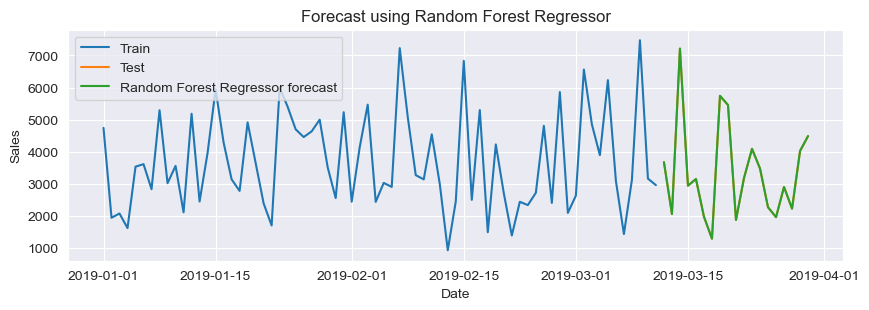

In [37]:
Plot(label = 'Random Forest Regressor forecast',title = 'Forecast using Random Forest Regressor', data1 = Y_train,data2 = Y_test,forecast = Y_pred['pred'])

# 14. Fit the model and forecast for XGBoost method

In [38]:
features = [ 'City_Mandalay', 'City_Naypyitaw', 'City_Yangon', 'Unit price', 'Total','Day Of Week','Branch_A', 'Branch_B','Branch_C']
X_trainXG = data_encoded[features]
Y_trainXG = data_encoded['Total']

X_testXG = data_encodedT[features]
Y_testXG = data_encodedT['Total']

XGmodel = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42, learning_rate = 0.1)
XGmodel.fit(X_trainXG, Y_trainXG)

Y_predXG = XGmodel.predict(X_testXG)
Y_predXG = pd.DataFrame(Y_predXG)
Y_testXG = pd.DataFrame(Y_testXG)
Y_testXG.reset_index(inplace = True)
Y_testXG['pred'] = Y_predXG

Y_testXG.set_index('Date', inplace=True)


Y_predXG = Y_testXG.groupby(['Date'])['pred'].sum()
Y_predXG = pd.DataFrame(Y_predXG)
Y_testXG= Y_testXG.groupby(['Date'])['Total'].sum()
Y_testXG = pd.DataFrame(Y_testXG)


Y_trainXG = pd.DataFrame(Y_trainXG)
Y_trainXG = Y_trainXG.groupby(['Date'])['Total'].sum()
Y_trainXG = pd.DataFrame(Y_trainXG)

feature_importances1 = RFmodel.feature_importances_

feature_importance_dict = dict(zip(X_train.columns, feature_importances1))

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance:.7f}")



Total: 0.9999260
Unit price: 0.0000459
Day Of Week: 0.0000152
City_Naypyitaw: 0.0000025
Branch_C: 0.0000024
Branch_B: 0.0000020
City_Yangon: 0.0000020
Branch_A: 0.0000020
City_Mandalay: 0.0000019


# 15. Plot the result

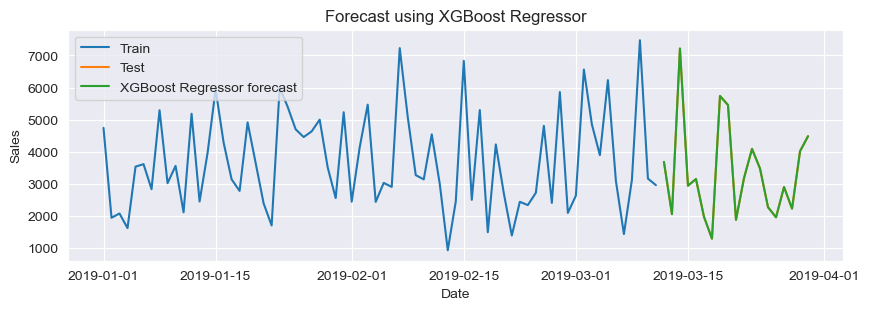

In [39]:
Plot(label = 'XGBoost Regressor forecast',title = 'Forecast using XGBoost Regressor', data1 = Y_trainXG, data2 = Y_testXG, forecast = Y_predXG['pred'])

In [40]:
features = [ 'City_Mandalay', 'City_Naypyitaw', 'City_Yangon', 'Unit price', 'Total','Day Of Week','Branch_A', 'Branch_B','Branch_C']
X_trainXGL = data_encoded[features]
Y_trainXGL = data_encoded['Total']
Y_trainXGL

lagXG = X_trainXGL['Total'].shift()
X_trainXGL['Lag_Variable'] = lagXG

X_trainXGL = X_trainXGL.iloc[1:]
Y_trainXGL = Y_trainXGL.iloc[1:]

X_testXGL = data_encodedT[features]
Y_testXGL = data_encodedT['Total']

lagXGT = X_testXGL['Total'].shift()
X_testXGL['Lag_Variable'] = lagXGT

X_testXGL = X_testXGL.iloc[1:]
Y_testXGL = Y_testXGL.iloc[1:]

XGmodelL = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42,learning_rate=0.1)
XGmodelL.fit(X_trainXGL, Y_trainXGL)

Y_predXGL = XGmodelL.predict(X_testXGL)
Y_predXGL = pd.DataFrame(Y_predXGL)
Y_testXGL = pd.DataFrame(Y_testXGL)
Y_testXGL.reset_index(inplace = True)
Y_testXGL['pred'] = Y_predXGL

Y_testXGL.set_index('Date', inplace=True)

Y_predXGL = Y_testXGL.groupby(['Date'])['pred'].sum()
Y_predXGL = pd.DataFrame(Y_predXGL)
Y_testXGL= Y_testXGL.groupby(['Date'])['Total'].sum()
Y_testXGL = pd.DataFrame(Y_testXGL)


Y_trainXGL = pd.DataFrame(Y_trainXGL)
Y_trainXGL = Y_trainXGL.groupby(['Date'])['Total'].sum()
Y_trainXGL = pd.DataFrame(Y_trainXGL)

feature_importances1L = XGmodelL.feature_importances_

feature_importance_dict1L = dict(zip(X_trainXGL.columns, feature_importances1L))

sorted_feature_importance1L = dict(sorted(feature_importance_dict1L.items(), key=lambda item: item[1], reverse=True))

for feature, importance in sorted_feature_importance1L.items():
    print(f"{feature}: {importance:.7f}")



Total: 0.9999360
Lag_Variable: 0.0000187
Unit price: 0.0000144
Day Of Week: 0.0000106
City_Yangon: 0.0000078
City_Mandalay: 0.0000064
City_Naypyitaw: 0.0000062
Branch_A: 0.0000000
Branch_B: 0.0000000
Branch_C: 0.0000000


# Calculate RMSE and MAPE 

In [41]:
def Evaluation(data2, forecast, method, results):

    rmse = np.sqrt(mean_squared_error(data2['Total'], forecast)).round(2)
    mape = np.round(np.mean(np.abs(data2['Total']-forecast)/data2['Total'])*100,2)
    
    results = results.append({'Method' : method, 'RMSE' : rmse, 'MAPE' : mape}, ignore_index = True)
    return results
    
    
    
results = pd.DataFrame(columns = ['Method', 'RMSE', 'MAPE'])
results = Evaluation(data2 = data2, forecast = forecastadd, method = 'Holt Winters\' additive method',results = results)    
results = Evaluation(data2 = data2, forecast = forecastmul, method = 'Holt Winters\' multiplicative method',results = results)    
results = Evaluation(data2 = Y_test, forecast = Y_pred['pred'], method = 'Random Forest Regressor method',results = results)    
results = Evaluation(data2 = Y_testXG, forecast = Y_predXG['pred'], method = 'XGBoost Regressor method',results = results)    
results = Evaluation(data2 = Y_testL, forecast = Y_predL['pred'], method = 'Random forest Regressor method with lag',results = results)    
results = Evaluation(data2 = Y_testXGL, forecast = Y_predXGL['pred'], method = 'XGBoost Regressor method with lag',results = results)    

results

,Method,RMSE,MAPE
0,Holt Winters' additive method,1818.49,63.81
1,Holt Winters' multiplicative method,1706.34,59.04
2,Random Forest Regressor method,2.60,0.07
3,XGBoost Regressor method,4.18,0.10
4,Random forest Regressor method with lag,3.01,0.07
5,XGBoost Regressor method with lag,3.83,0.10


From RMSE and MAPE values for the different implemented forecasting methods, We can conclude that Random Forest method is the better method for this time series data to predict the sales.

In [42]:
import platform

# Get the operating system
os_info = platform.system()

# Get the CPU information
cpu_info = platform.processor()

# Get the Python version
python_version = platform.python_version()

# Print the results
print(f"Operating System: {os_info}")
print(f"CPU Info: {cpu_info}")
print(f"Python Version: {python_version}")


Operating System: Windows
CPU Info: Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
Python Version: 3.9.13


In [43]:
import os

# Get the number of CPU cores
cpu_cores = os.cpu_count()

# Print the number of CPU cores
print(f"Number of CPU Cores: {cpu_cores}")


Number of CPU Cores: 8


In [44]:
import psutil

# Get memory (RAM) information
memory_info = psutil.virtual_memory()

# Get disk usage information for a specific directory (e.g., '/')
disk_info = psutil.disk_usage('/')

# Print memory and disk usage information
print(f"Memory Usage: {memory_info}")
print(f"Disk Usage: {disk_info}")


Memory Usage: svmem(total=8406261760, available=1061318656, percent=87.4, used=7344943104, free=1061318656)
Disk Usage: sdiskusage(total=495396581376, used=181745930240, free=313650651136, percent=36.7)
